# Data description
**1. Gold prices and volume:**
- gold_open: Opening price of gold for the trading day
- gold_high: Highest price of gold during the trading day
- gold_low: Lowest price of gold during the trading day
- gold_close: Closing price of gold during the trading day. Used in trend analysis and modeling.
- gold_volume: Volume of gold traded, reflecting market activity and liquidity

**2. Other precious metals and energy commodities:**
- silver_close
- platinum_close
- palladium_close
- oil_close

**3. Financial market indices:**
- sp500 close: Closing value of the S&P 500 Index, representing the performance of 500 large-cap US companies
- nasdaq_close: Closing value of the NASDAQ Index, dominated by technology companies

**4. Currency exchange rates**
- usd_chf: Exchange rate between USD and CHF
- eur_usd: Exchange rate between EUR and USD

**5. Economic indicators:**
- CPI: Consumer Price Index. Indicator of inflation
- GDP: Gross Domestic Product. Indicating economic health and growth
- us_rates_%: Federal funds rate or other key interest rates in the United States, expressed as a percentage

# Load and analyze data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv('../financial_regression.csv', sep = ',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                3904 non-null   object 
 1   sp500 open          3719 non-null   float64
 2   sp500 high          3719 non-null   float64
 3   sp500 low           3719 non-null   float64
 4   sp500 close         3719 non-null   float64
 5   sp500 volume        3719 non-null   float64
 6   sp500 high-low      3719 non-null   float64
 7   nasdaq open         3719 non-null   float64
 8   nasdaq high         3719 non-null   float64
 9   nasdaq low          3719 non-null   float64
 10  nasdaq close        3719 non-null   float64
 11  nasdaq volume       3719 non-null   float64
 12  nasdaq high-low     3719 non-null   float64
 13  us_rates_%          176 non-null    float64
 14  CPI                 176 non-null    float64
 15  usd_chf             3694 non-null   float64
 16  eur_us

We observe missing data for indicators such as CPI, GDP and us_rates_%. This is because we have monthly data for CPI and us_rates_%, while for GDP we have trimestral data available. In order to fill all the columns we fill the missing data with the next available data of every first day of the month, so then we have all the month filled with the corresponding data.

In [3]:
columns_to_fill = ['us_rates_%', 'CPI', 'GDP']
data[columns_to_fill] = data[columns_to_fill].fillna(method='bfill') # fill with next available data of the column
# Verify that missing data has been filled
display(data[columns_to_fill].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   us_rates_%  3866 non-null   float64
 1   CPI         3866 non-null   float64
 2   GDP         3755 non-null   float64
dtypes: float64(3)
memory usage: 91.6 KB


None

After backfilling, missing data for these indicators is significantly reduced, as shown in the heatmap below.

In [4]:
# Convert date to Datetime
data['date'] = pd.to_datetime(data['date'])
# Set the variable as an index
data.set_index('date', inplace=True)

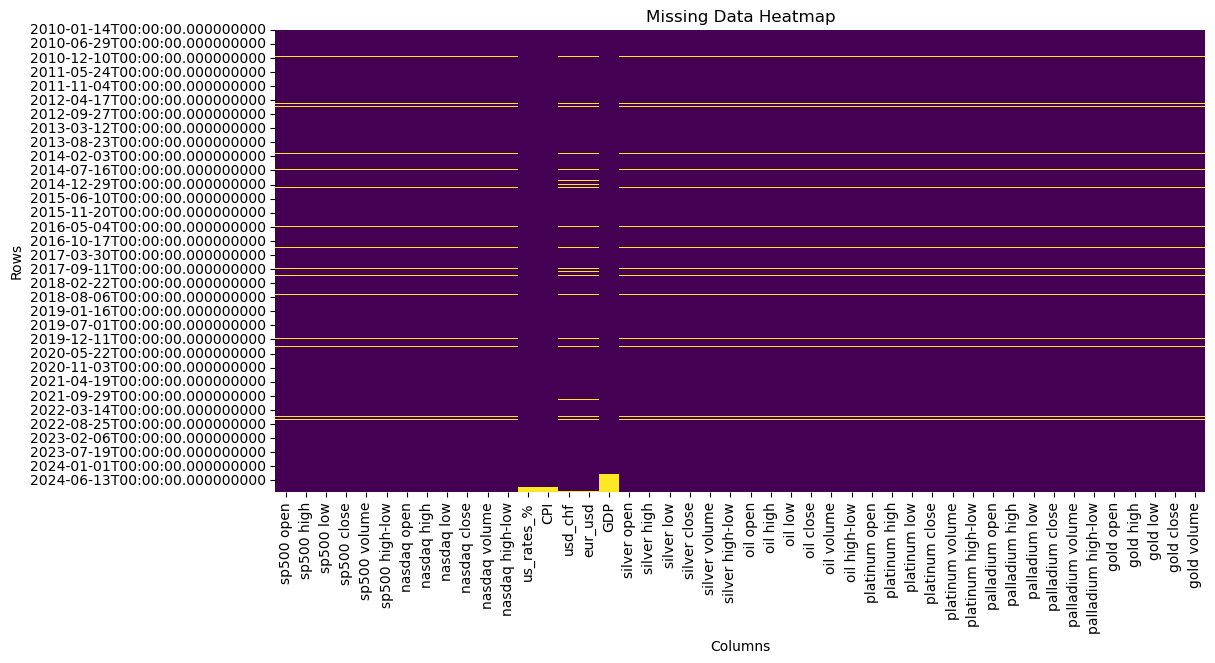

In [5]:
# Visualize missing data
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

The heatmap above highlights the missing data. We observe that there are some empty rows that we could consider to eliminate in order to avoid their impact in their usability in analysis or modeling. ALso it is worth to mention that we don't have data on the CPI, us_rates_% and GDP indicators for the last months of 2024. It could be either interesting to search for the data and fil the missing values or either leave it like that, given the sufficient historical data available for analysis.

In [6]:
# Eliminate rows with NaN values
data_cleaned = data.dropna()
print(f"Original data shape: {data.shape}")
print(f"Cleaned data shape: {data_cleaned.shape}")

Original data shape: (3904, 46)
Cleaned data shape: (3538, 46)


# Summary statistics

In [7]:
data.describe()

,sp500 open,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,nasdaq open,nasdaq high,nasdaq low,nasdaq close,...,palladium high,palladium low,palladium close,palladium volume,palladium high-low,gold open,gold high,gold low,gold close,gold volume
count,3719.000000,3719.000000,3719.000000,3719.000000,3.719000e+03,3719.000000,3719.000000,3719.000000,3719.00000,3719.000000,...,3719.000000,3719.000000,3719.000000,3.719000e+03,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3.719000e+03
mean,268.732724,270.179765,267.157446,268.779352,1.124206e+08,3.022320,181.394495,182.689784,179.98249,181.431795,...,110.184473,107.931862,109.067990,7.169556e+04,2.252611,145.454975,146.101477,144.761329,145.453861,9.658138e+06
std,121.374890,122.024860,120.663204,121.393684,6.902901e+07,2.656917,122.468973,123.393400,121.43517,122.473492,...,58.454170,56.877967,57.688191,9.790703e+04,2.543622,29.604259,29.754711,29.422517,29.611348,6.182342e+06
min,103.110000,103.420000,101.130000,102.200000,1.708170e+05,0.300000,42.670000,42.821500,41.55000,42.470000,...,40.550000,38.490000,40.090000,3.157000e+03,0.230000,100.920000,100.990000,100.232600,100.500000,1.436508e+06
25%,169.715000,170.175000,169.030000,169.650000,6.699112e+07,1.280000,78.700000,79.150000,78.31500,78.730000,...,69.400000,68.270000,68.820000,2.085900e+04,0.870000,120.555000,121.030000,120.170000,120.590000,5.795310e+06
50%,241.180000,242.080000,239.450000,240.610000,9.239907e+07,2.090000,138.720000,139.420000,138.02000,139.050000,...,83.900000,82.650000,83.210000,3.829500e+04,1.414000,137.620000,138.140000,136.990000,137.710000,8.087993e+06
75%,374.455000,377.800000,371.045000,374.255000,1.367146e+08,3.815000,284.165000,287.590000,281.23000,284.835000,...,143.785000,140.480000,142.040000,8.420700e+04,2.680000,167.770000,168.412500,167.055000,167.835000,1.156729e+07
max,585.910000,586.120000,582.580000,584.590000,7.095045e+08,22.960000,503.070000,503.520000,498.39000,502.960000,...,298.210000,277.000100,295.000000,1.199042e+06,45.392300,253.080000,253.940000,252.520000,253.930000,9.369811e+07


# Historical gold prices and correlation analysis

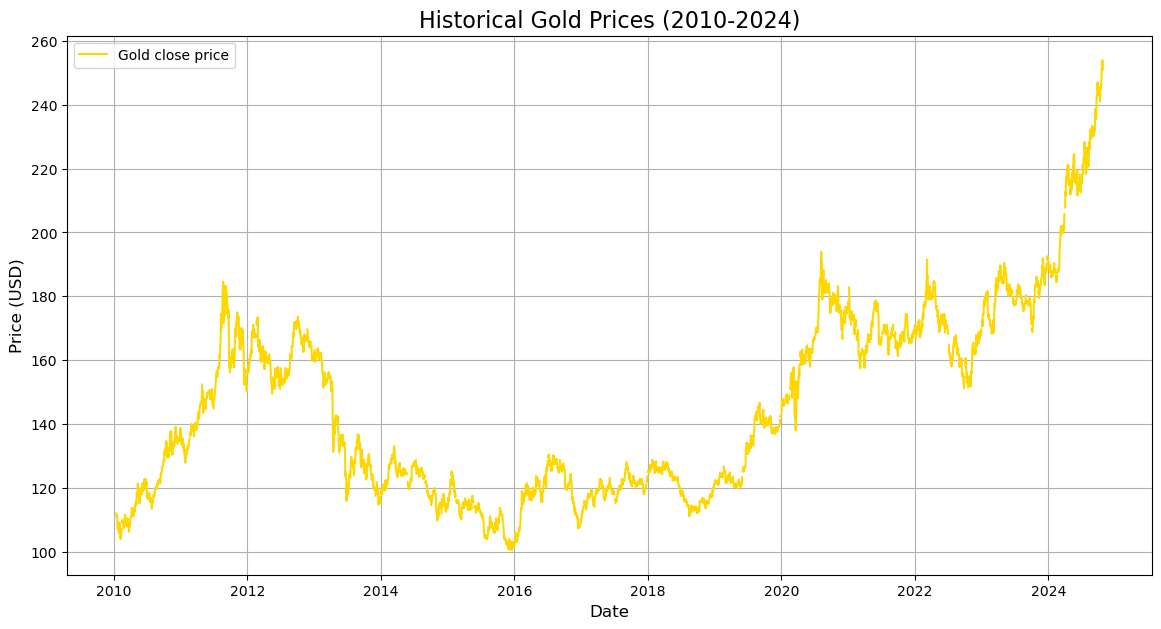

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['gold close'], label='Gold close price', color='gold')
plt.title('Historical Gold Prices (2010-2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Analysis of global events impacting gold price trends
**2008–2011: Aftermath of the Global Financial Crisis:**
The 2008 financial crisis caused widespread economic instability and a loss of confidence in financial markets, driving gold prices to record highs as investors sought a reliable store of value. Gold prices remained elevated through 2011, fueled by concerns over sovereign debt crises in Europe and quantitative easing policies by central banks, which raised inflation fears.

**2013–2015: Taper Tantrum and Economic Recovery:**
Gold prices declined significantly during this period as the U.S. Federal Reserve announced plans to taper its quantitative easing program. This led to rising confidence in equity markets and a stronger U.S. dollar, reducing gold's appeal. Economic recovery in developed nations further contributed to declining demand for gold.

**2016: Brexit and Political Uncertainty:**
The U.K.'s decision to leave the European Union (Brexit) triggered a brief surge in gold prices due to heightened uncertainty in global markets. This event highlighted gold's role as a hedge during periods of geopolitical instability.

**2020: COVID-19 Pandemic:**
The onset of the COVID-19 pandemic led to a sharp spike in gold prices, as economic shutdowns and a global recession caused market turmoil. Central banks responded with aggressive monetary easing, further boosting gold's appeal. By mid-2020, gold reached an all-time high, driven by fears of prolonged uncertainty and inflationary pressures.

**2022: Rising Interest Rates and Strong U.S. Dollar:**
In response to surging inflation, the U.S. Federal Reserve and other central banks implemented aggressive interest rate hikes. Higher interest rates reduced gold's attractiveness as a non-yielding asset. Additionally, a strong U.S. dollar made gold more expensive for international buyers, leading to a decline in demand and prices.

**2022–2024: Ongoing Geopolitical Tensions and Economic Adjustments:**
Events like the Russia-Ukraine conflict, fluctuating energy prices, and fears of a global economic slowdown have introduced volatility into gold prices. While geopolitical tensions supported gold as a safe-haven asset, these were counterbalanced by central banks' efforts to stabilize inflation through monetary tightening.

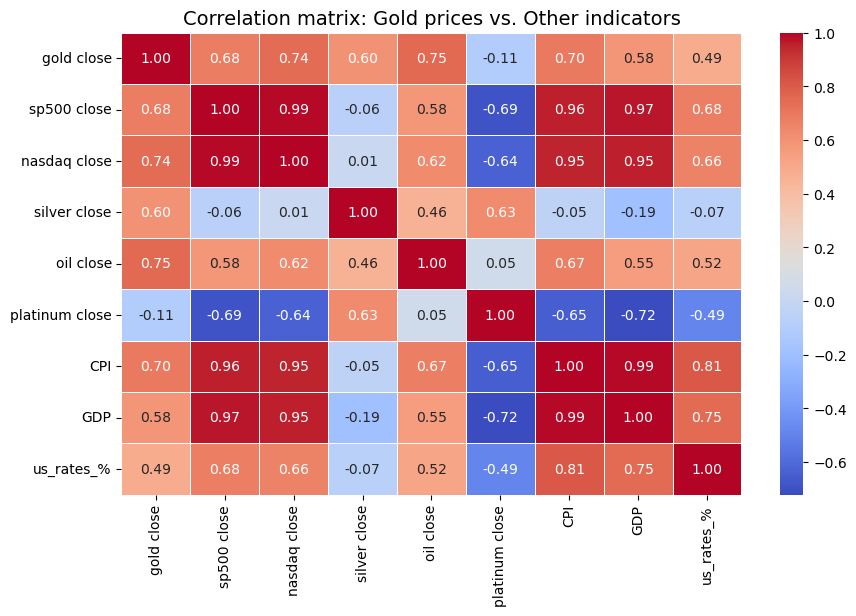

In [9]:
selected_columns = ['gold close', 'sp500 close', 'nasdaq close', 'silver close', 'oil close', 'platinum close', 'CPI', 'GDP', 'us_rates_%']
correlation_data = data[selected_columns]
# Correlation matrix
correlation_matrix = correlation_data.corr()
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix: Gold prices vs. Other indicators', fontsize=14)
plt.show()

This heatmap shows the strength and direction of correlations between gold prices and other financial indicators. For instance, gold correlate strongly with oil prices and indices like nasdaq or CPI, but less with prices like platinum.

# Comparison

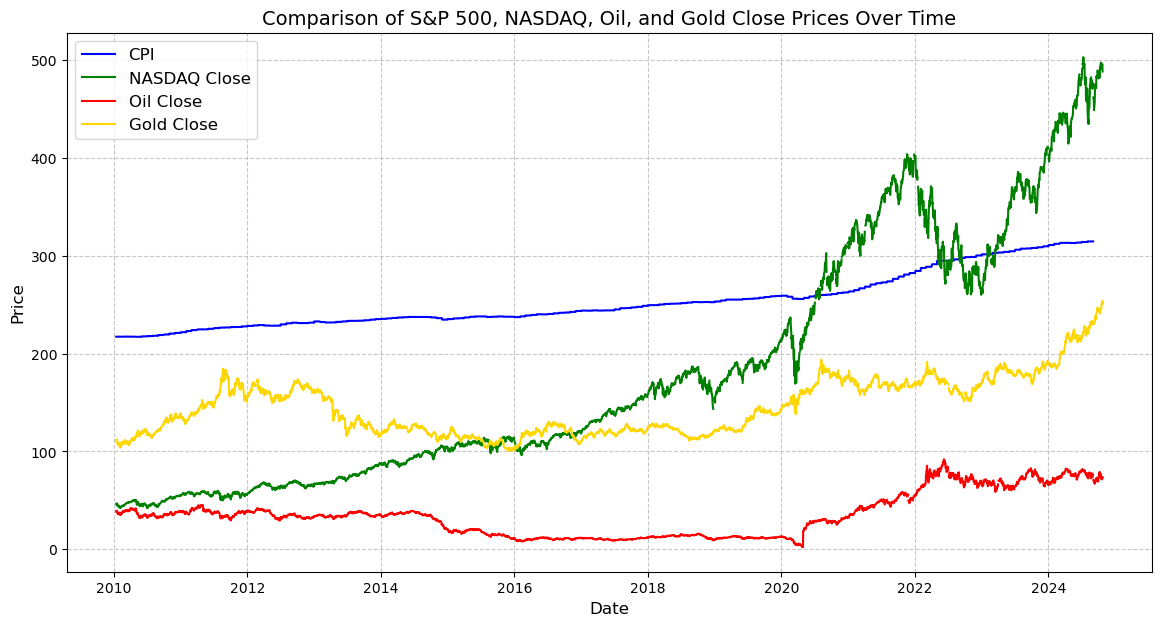

In [10]:
# Plotting multiple lines for most correlated variables
plt.figure(figsize=(14, 7))

# Plot CPI close
plt.plot(data.index, data['CPI'], label='CPI', color='blue')

# Plot NASDAQ close
plt.plot(data.index, data['nasdaq close'], label='NASDAQ Close', color='green')

# Plot Oil close
plt.plot(data.index, data['oil close'], label='Oil Close', color='red')

# Plot Gold close
plt.plot(data.index, data['gold close'], label='Gold Close', color='gold')

plt.title('Comparison of S&P 500, NASDAQ, Oil, and Gold Close Prices Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# Further analysis and preprocessing for the visual tool

In [11]:
# Create 'month' and 'year' columns
data['month'] = data.index.month # 1,2,...12
data['year'] = data.index.year

Monthly average gold prices

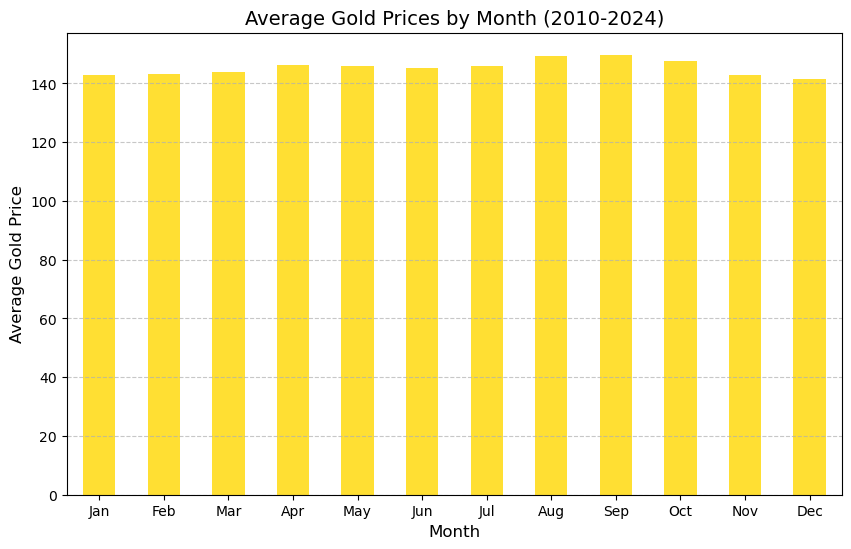

In [12]:
# Group by month to calculate the average gold close price
monthly_avg_gold = data.groupby('month')['gold close'].mean()

plt.figure(figsize=(10, 6))
monthly_avg_gold.plot(kind='bar', color='gold', alpha=0.8)
plt.title('Average Gold Prices by Month (2010-2024)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Gold Price', fontsize=12)
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Yearly trends in gold prices

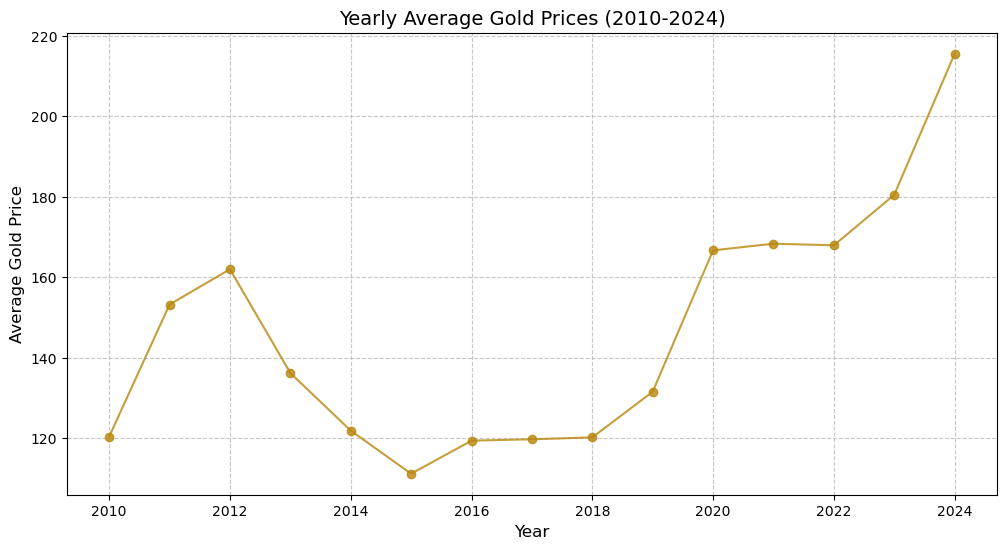

In [13]:
# Group by year to calculate the average gold close price
yearly_avg_gold = data.groupby('year')['gold close'].mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_avg_gold.index, yearly_avg_gold.values, marker='o', color='darkgoldenrod', alpha=0.8)
plt.title('Yearly Average Gold Prices (2010-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Gold Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Download the final dataset

In [14]:
data.to_csv('final_dataset.csv')
data = pd.read_csv('final_dataset.csv')

Model Evaluation Metrics:
Mean Squared Error (MSE): 71.72
Mean Absolute Error (MAE): 7.65
R^2 Score: -0.76


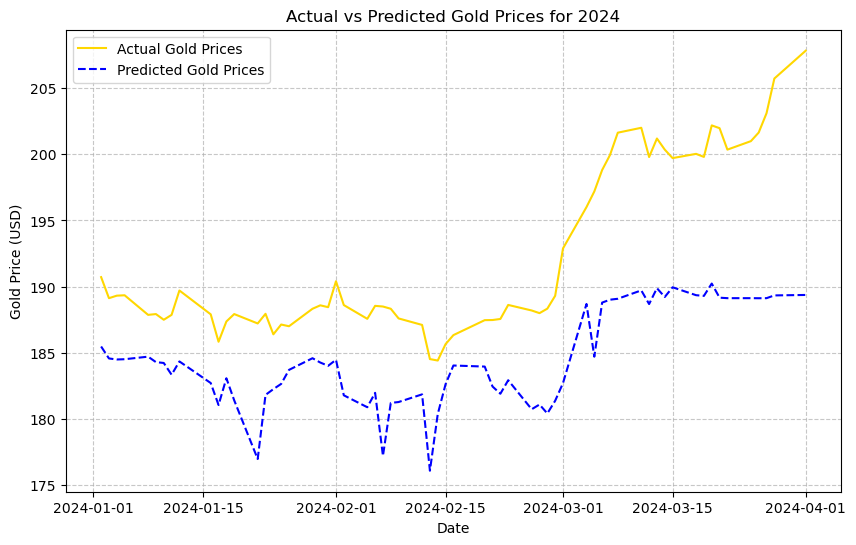

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load the Dataset
data = pd.read_csv('../financial_regression.csv')

# Step 2: Convert the 'date' column to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Step 3: Fill missing values for selected columns
columns_to_fill = ['us_rates_%', 'CPI', 'GDP']
data[columns_to_fill] = data[columns_to_fill].fillna(method='bfill')

# Step 4: Drop remaining rows with missing values
data_cleaned = data.dropna()

# Step 5: Define features and target variable
selected_features = [
    'sp500 close', 'nasdaq close', 'silver close', 'oil close',
    'platinum close', 'CPI', 'GDP', 'us_rates_%'
]
target = 'gold close'

X = data_cleaned[selected_features]
y = data_cleaned[target]

# Step 6: Train-test split (train on 2010-2023, test on 2024)
train_mask = data_cleaned.index < "2024-01-01"
test_mask = data_cleaned.index >= "2024-01-01"

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Step 7: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 9: Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Step 10: Plot actual vs predicted prices for 2024
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual Gold Prices", color='gold')
plt.plot(y_test.index, y_pred, label="Predicted Gold Prices", color='blue', linestyle='--')
plt.title("Actual vs Predicted Gold Prices for 2024")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Step 11: Predict for 2025
# Assuming we have 2025 input features (e.g., forecasted data or repeating recent trends)
# Prepare a placeholder dataframe for 2025 and use the model to predict


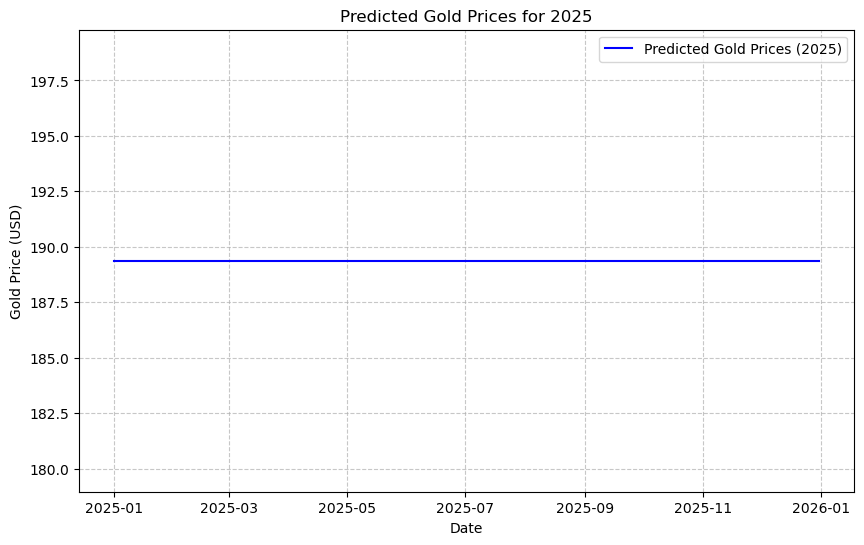

Predictions for 2025 saved to 'gold_price_predictions_2025.csv'


In [3]:
# Step 1: Create a Placeholder for 2025 Features
# Example: Repeat the last available values for simplicity (or forecast your own)
last_available_data = X.iloc[-1]  # Take the most recent available data
dates_2025 = pd.date_range(start="2025-01-01", end="2025-12-31", freq="B")  # Business days
X_2025 = pd.DataFrame([last_available_data.values] * len(dates_2025), columns=X.columns, index=dates_2025)

# Optional: Replace with forecasted or assumed data
# For example, increment CPI by 2% year-over-year (assumption):
X_2025['CPI'] *= 1.02

# Step 2: Standardize the 2025 Features Using the Same Scaler
X_2025_scaled = scaler.transform(X_2025)

# Step 3: Predict Gold Prices for 2025
y_2025_pred = model.predict(X_2025_scaled)

# Step 4: Visualize Predicted Gold Prices for 2025
plt.figure(figsize=(10, 6))
plt.plot(X_2025.index, y_2025_pred, label="Predicted Gold Prices (2025)", color='blue')
plt.title("Predicted Gold Prices for 2025")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Step 5: Save Predictions to a CSV File
predictions_2025 = pd.DataFrame({'date': X_2025.index, 'predicted_gold_close': y_2025_pred})
predictions_2025.to_csv("gold_price_predictions_2025.csv", index=False)
print("Predictions for 2025 saved to 'gold_price_predictions_2025.csv'")


Model Evaluation Metrics:
Mean Squared Error (MSE): 71.72
Mean Absolute Error (MAE): 7.65
R^2 Score: -0.76


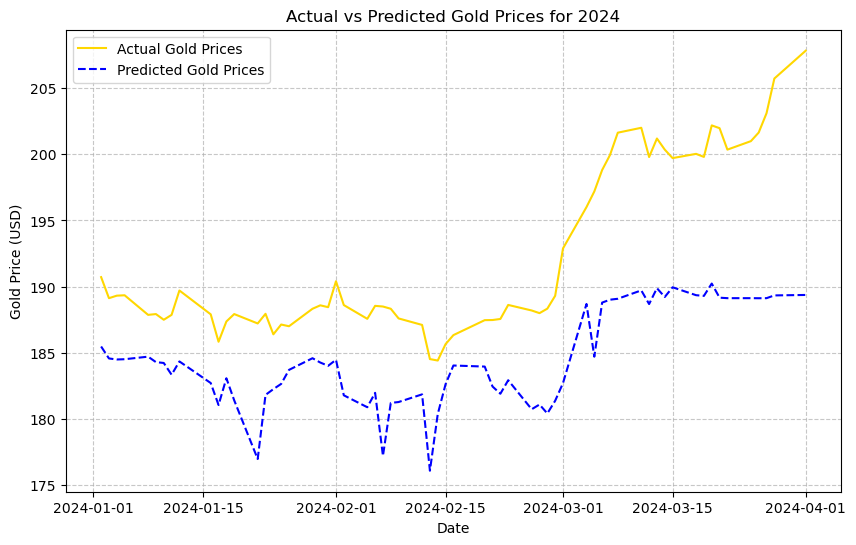

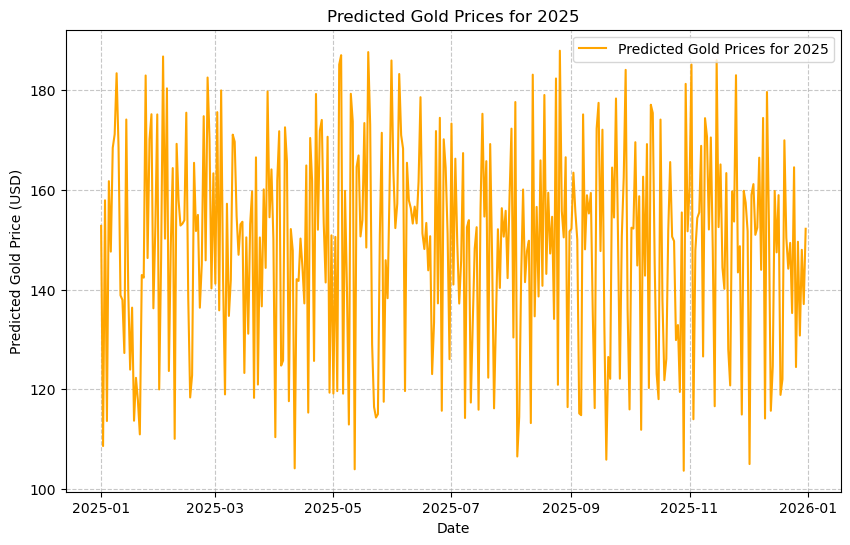

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load the Dataset
data = pd.read_csv('../financial_regression.csv')

# Step 2: Convert the 'date' column to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Step 3: Fill missing values for selected columns
columns_to_fill = ['us_rates_%', 'CPI', 'GDP']
data[columns_to_fill] = data[columns_to_fill].fillna(method='bfill')

# Step 4: Drop remaining rows with missing values
data_cleaned = data.dropna()

# Step 5: Define features and target variable
selected_features = [
    'sp500 close', 'nasdaq close', 'silver close', 'oil close',
    'platinum close', 'CPI', 'GDP', 'us_rates_%'
]
target = 'gold close'

X = data_cleaned[selected_features]
y = data_cleaned[target]

# Step 6: Train-test split (train on 2010-2023, test on 2024)
train_mask = data_cleaned.index < "2024-01-01"
test_mask = data_cleaned.index >= "2024-01-01"

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Step 7: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 9: Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Step 10: Plot actual vs predicted prices for 2024
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual Gold Prices", color='gold')
plt.plot(y_test.index, y_pred, label="Predicted Gold Prices", color='blue', linestyle='--')
plt.title("Actual vs Predicted Gold Prices for 2024")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Step 11: Predict for 2025
# Assuming we have 2025 input features (e.g., forecasted data or repeating recent trends)

# For simplicity, let's generate synthetic data for 2025
# We will generate data for the features by using random variations based on the mean and standard deviation from the training set

# Create a placeholder dataframe for 2025, with synthetic data
num_samples_2025 = 365  # Number of days in 2025, assuming daily data
np.random.seed(42)  # For reproducibility

# Generate synthetic data for each feature based on mean and std from the training set
synthetic_data_2025 = {}

for feature in selected_features:
    mean_val = X_train[feature].mean()
    std_val = X_train[feature].std()
    
    # Generate random data based on the mean and standard deviation
    synthetic_data_2025[feature] = np.random.normal(mean_val, std_val, num_samples_2025)

# Convert the synthetic data to a DataFrame
data_2025 = pd.DataFrame(synthetic_data_2025)

# Standardize the 2025 data using the same scaler
X_2025_scaled = scaler.transform(data_2025)

# Predict gold prices for 2025
gold_price_2025_pred = model.predict(X_2025_scaled)

# Convert the predicted values to a DataFrame for easy visualization
predictions_2025 = pd.DataFrame({'Date': pd.date_range(start='2025-01-01', periods=num_samples_2025, freq='D'),
                                  'Predicted Gold Price': gold_price_2025_pred})

# Plot the predictions for 2025
plt.figure(figsize=(10, 6))
plt.plot(predictions_2025['Date'], predictions_2025['Predicted Gold Price'], label="Predicted Gold Prices for 2025", color='orange')
plt.title("Predicted Gold Prices for 2025")
plt.xlabel("Date")
plt.ylabel("Predicted Gold Price (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


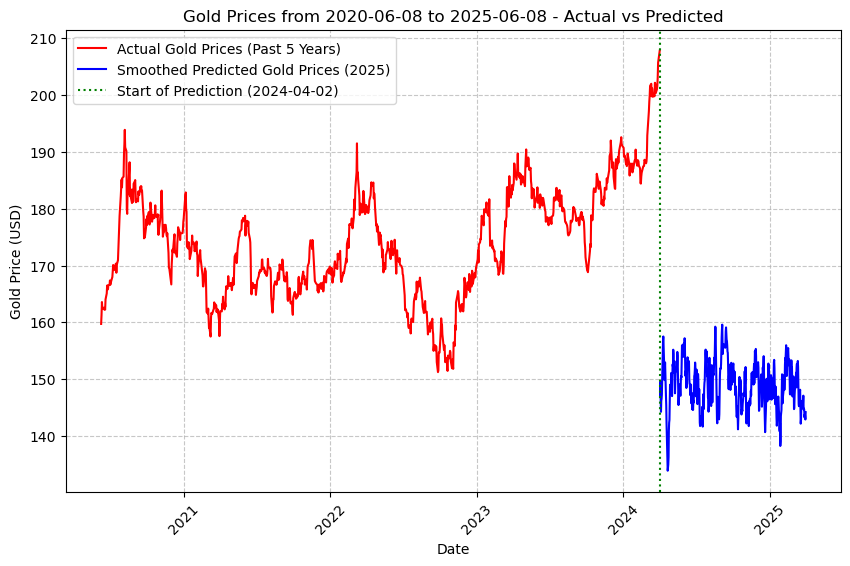

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import make_interp_spline

# Assuming your model and data have been set up as previously discussed, including scaling and training
# Generate synthetic data for 2025 (from the previous code snippet)
num_samples_2025 = 365  # Number of days in 2025, assuming daily data
np.random.seed(42)  # For reproducibility

# Generate synthetic data for each feature based on mean and std from the training set
synthetic_data_2025 = {}

for feature in selected_features:
    mean_val = X_train[feature].mean()
    std_val = X_train[feature].std()
    
    # Generate random data based on the mean and standard deviation
    synthetic_data_2025[feature] = np.random.normal(mean_val, std_val, num_samples_2025)

# Convert the synthetic data to a DataFrame
data_2025 = pd.DataFrame(synthetic_data_2025)

# Standardize the 2025 data using the same scaler
X_2025_scaled = scaler.transform(data_2025)

# Predict gold prices for 2025
gold_price_2025_pred = model.predict(X_2025_scaled)

# Apply a rolling average with a larger window for stronger smoothing
smoothed_predictions_rolling = pd.Series(gold_price_2025_pred).rolling(window=15, min_periods=1).mean()

# Apply Exponential Moving Average (EMA) for further smoothing
smoothed_predictions_ema = pd.Series(gold_price_2025_pred).ewm(span=15, adjust=False).mean()

# Convert the predicted values to a DataFrame for easy visualization
predictions_2025 = pd.DataFrame({
    'Date': pd.date_range(start='2024-04-01', periods=num_samples_2025, freq='D'),
    'Predicted Gold Price': smoothed_predictions_ema  # Use the EMA for smoother results
})

# Function to plot past 5 years of actual gold prices (in red) and predicted prices (in blue)
def plot_gold_prices(input_date):
    # Convert the input date to datetime object
    input_date = pd.to_datetime(input_date)
    
    # Get the actual data for the past 5 years from the cleaned dataset
    end_date = input_date
    start_date = end_date.replace(year=end_date.year - 5)
    
    # Actual data from the past 5 years
    past_data = data_cleaned.loc[start_date:end_date, ['gold close']]

    # Get the last day of 2024 for the start of prediction
    last_day_2024 = datetime(2024, 4, 2)

    # Filter predictions for 2025 (from last_day_2024 onward)
    future_predictions_2025 = predictions_2025[predictions_2025['Date'] >= last_day_2024]

    # Only keep predictions until the input date in 2025
    future_predictions_2025 = future_predictions_2025[future_predictions_2025['Date'] <= input_date]

    # Convert the 'Date' column to integer representation (number of days since Unix epoch)
    future_predictions_2025['Date_int'] = future_predictions_2025['Date'].apply(lambda x: x.value // 10**9)

    # Interpolate for smoother predictions (optional, if you want even smoother curves)
    spline = make_interp_spline(future_predictions_2025['Date_int'].values, future_predictions_2025['Predicted Gold Price'].values)
    
    # Create a smoother set of dates
    dates_smooth_int = np.linspace(future_predictions_2025['Date_int'].min(), future_predictions_2025['Date_int'].max(), 500)
    prices_smooth = spline(dates_smooth_int)

    # Convert the integer-based smooth dates back to datetime objects
    dates_smooth = pd.to_datetime(dates_smooth_int * 10**9)

    # Plot the actual and predicted prices
    plt.figure(figsize=(10, 6))
    
    # Plot actual data (past 5 years)
    plt.plot(past_data.index, past_data['gold close'], label="Actual Gold Prices (Past 5 Years)", color='red')

    # Plot predicted data from last day of 2024 onward (smoother curve)
    plt.plot(dates_smooth, prices_smooth, label="Smoothed Predicted Gold Prices (2025)", color='blue')

    predicted_start_date = datetime(2024, 4, 2)
    plt.axvline(x=predicted_start_date, color='green', linestyle=':', label='Start of Prediction (2024-04-02)')
    
    
    # Add labels and title
    plt.title(f"Gold Prices from {start_date.date()} to {end_date.date()} - Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (USD)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.show()

# Example of how to call the plot function
# Get input from the user for a specific date (year, month, day)
input_date = input("Enter a date for the prediction (YYYY-MM-DD): ")

# Call the function to plot the data
plot_gold_prices(input_date)


**MODEL MOLT VALID**

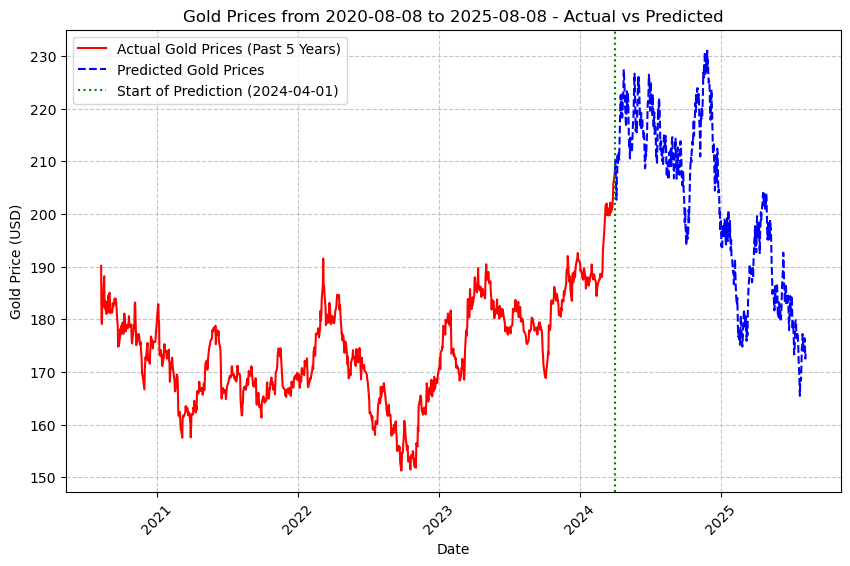

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming your model and data have been set up as previously discussed, including scaling and training
# Generate synthetic data for 2025 (from the previous code snippet)
num_samples_2025 = 365  # Number of days in 2025, assuming daily data
np.random.seed(42)  # For reproducibility

# Generate synthetic data for each feature based on mean and std from the training set
synthetic_data_2025 = {}

for feature in selected_features:
    mean_val = X_train[feature].mean()
    std_val = X_train[feature].std()
    
    # Generate random data based on the mean and standard deviation
    synthetic_data_2025[feature] = np.random.normal(mean_val, std_val, num_samples_2025)

# Convert the synthetic data to a DataFrame
data_2025 = pd.DataFrame(synthetic_data_2025)

# Standardize the 2025 data using the same scaler
X_2025_scaled = scaler.transform(data_2025)

# Predict gold prices for 2025
gold_price_2025_pred = model.predict(X_2025_scaled)

# Convert the predicted values to a DataFrame for easy visualization
predictions_2025 = pd.DataFrame({
    'Date': pd.date_range(start='2024-04-01', periods=num_samples_2025, freq='D'),
    'Predicted Gold Price': gold_price_2025_pred
})

# Function to plot past 5 years of actual gold prices (in red) and predicted prices (in blue)
def plot_gold_prices(input_date):
    # Convert the input date to datetime object
    input_date = pd.to_datetime(input_date)
    
    # Get the actual data for the past 5 years from the cleaned dataset
    end_date = input_date
    start_date = end_date.replace(year=end_date.year - 5)
    
    # Actual data from the past 5 years
    past_data = data_cleaned.loc[start_date:end_date, ['gold close']]

    # Get the last day of 2024 for the start of prediction (last date of actual data is 2024-04-01)
    last_day_2024 = datetime(2024, 4, 1)  # Last actual price date

    # Get the last actual price before 2025 starts
    last_actual_price = past_data['gold close'].iloc[-1]
    
    # Generate predictions starting from the last actual price (2024-04-01)
    predicted_prices = [last_actual_price]
    for i in range(1, (input_date - last_day_2024).days + 1):  # Predict until input_date
        # Simulate a small random fluctuation in price (within +/- 2%)
        daily_change = np.random.uniform(-0.02, 0.02)
        predicted_prices.append(predicted_prices[-1] * (1 + daily_change))
    
    # Update the predictions_2025 dataframe with the generated predicted prices until input_date
    predictions_2025 = pd.DataFrame({
        'Date': pd.date_range(start=last_day_2024, periods=len(predicted_prices), freq='D'),
        'Predicted Gold Price': predicted_prices
    })

    # Plot the actual and predicted prices
    plt.figure(figsize=(10, 6))
    
    # Plot actual data (past 5 years)
    plt.plot(past_data.index, past_data['gold close'], label="Actual Gold Prices (Past 5 Years)", color='red')

    # Plot the combined data (last actual data and predicted future data)
    plt.plot(predictions_2025['Date'], predictions_2025['Predicted Gold Price'], label="Predicted Gold Prices", color='blue', linestyle='--')
    
    # Add a vertical line to indicate the start of predicted data (2024-04-01)
    plt.axvline(x=last_day_2024, color='green', linestyle=':', label='Start of Prediction (2024-04-01)')
    
    # Add labels and title
    plt.title(f"Gold Prices from {start_date.date()} to {end_date.date()} - Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (USD)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.show()

# Example of how to call the plot function
# Get input from the user for a specific date (year, month, day)
input_date = input("Enter a date for the prediction (YYYY-MM-DD): ")

# Call the function to plot the data
plot_gold_prices(input_date)


Combined data saved to 'gold_prices_until_2030.pkl'


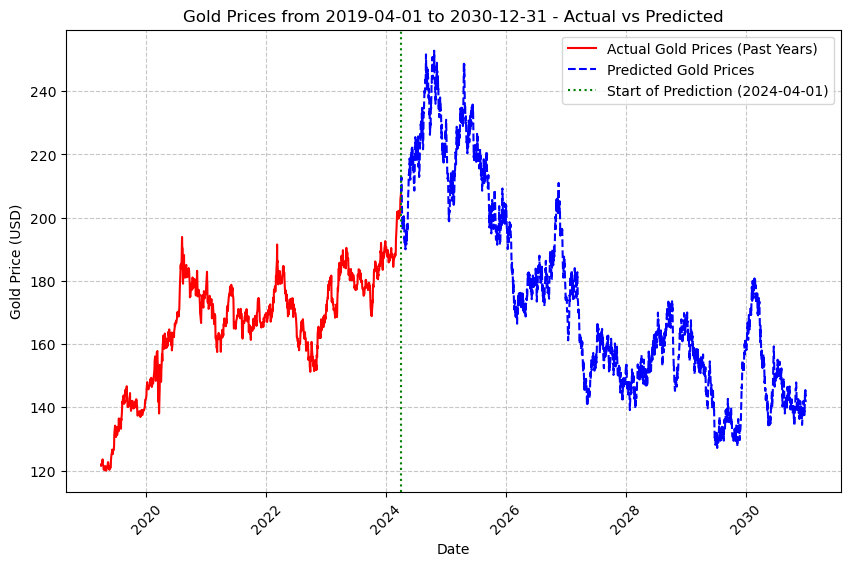

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle

# Assuming your model and data have been set up as previously discussed, including scaling and training
# Generate synthetic data for 2025 (from the previous code snippet)
num_samples_until_2030 = (datetime(2030, 12, 31) - datetime(2024, 4, 1)).days + 1  # Calculate total days from 2024-04-01 to 2030-12-31
np.random.seed(42)  # For reproducibility

# Assuming you already have 'data_cleaned' for past gold prices, and 'selected_features', 'scaler', 'model'

# Generate synthetic data for each feature based on mean and std from the training set
synthetic_data_until_2030 = {}

for feature in selected_features:
    mean_val = X_train[feature].mean()
    std_val = X_train[feature].std()
    
    # Generate random data based on the mean and standard deviation
    synthetic_data_until_2030[feature] = np.random.normal(mean_val, std_val, num_samples_until_2030)

# Convert the synthetic data to a DataFrame
data_until_2030 = pd.DataFrame(synthetic_data_until_2030)

# Standardize the 2025 data using the same scaler
X_until_2030_scaled = scaler.transform(data_until_2030)

# Predict gold prices from 2024-04-01 to 2030
gold_price_until_2030_pred = model.predict(X_until_2030_scaled)

# Convert the predicted values to a DataFrame for easy visualization
predictions_until_2030 = pd.DataFrame({
    'Date': pd.date_range(start='2024-04-01', periods=num_samples_until_2030, freq='D'),
    'Predicted Gold Price': gold_price_until_2030_pred
})

# Get the actual data for the past years (from 2019-04-01 to 2024-04-01)
# Assuming you have 'data_cleaned' with the column 'gold close' and datetime index
past_data = data_cleaned.loc['2019-04-01':'2024-04-01', ['gold close']]

# Get the last actual price before 2025 starts (2024-04-01)
last_actual_price = past_data['gold close'].iloc[-1]

# Generate predictions starting from the last actual price (2024-04-01)
predicted_prices = [last_actual_price]

# Simulate daily price changes with small random fluctuations (within +/- 2%)
for i in range(1, num_samples_until_2030):  # Predict until 2030
    daily_change = np.random.uniform(-0.02, 0.02)  # Daily fluctuation +/- 2%
    predicted_prices.append(predicted_prices[-1] * (1 + daily_change))

# Create the dataframe for predicted prices until 2030
predictions = pd.DataFrame({
    'Date': pd.date_range(start='2024-04-01', periods=num_samples_until_2030, freq='D'),
    'Predicted Gold Price': predicted_prices
})

# Combine past data and predicted data
combined_data = pd.concat([past_data, predictions.set_index('Date')], axis=0)

# Store the combined predictions and actual data in a .pkl file
combined_data.to_pickle('gold_prices_until_2030.pkl')

print("Combined data saved to 'gold_prices_until_2030.pkl'")

# Plot the actual and predicted prices
plt.figure(figsize=(10, 6))

# Plot actual data (past years)
plt.plot(past_data.index, past_data['gold close'], label="Actual Gold Prices (Past Years)", color='red')

# Plot the combined data (last actual data and predicted future data)
plt.plot(predictions['Date'], predictions['Predicted Gold Price'], label="Predicted Gold Prices", color='blue', linestyle='--')

# Add a vertical line to indicate the start of predicted data (2024-04-01)
plt.axvline(x=datetime(2024, 4, 1), color='green', linestyle=':', label='Start of Prediction (2024-04-01)')

# Add labels and title
plt.title(f"Gold Prices from 2019-04-01 to 2030-12-31 - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

# To load the saved predictions later:
# loaded_predictions = pd.read_pickle('gold_prices_until_2030.pkl')
# print(loaded_predictions.head())
